## How good is your Explanation
### Algorithmic Stability Measures to Assess the Quality of Explanations for Deep Neural Networks
NoteBook Deep Learning Guillaume BERTHELOT


This notebook is freely inspired by the article ["How good is Your Explanation"](https://openaccess.thecvf.com/content/WACV2022/html/Fel_How_Good_Is_Your_Explanation_Algorithmic_Stability_Measures_To_Assess_WACV_2022_paper.html)

[1] Fel, Thomas and Vigouroux, David and Cadène, Rémi and Serre, Thomas, "How Good Is Your Explanation? Algorithmic Stability Measures To Assess the Quality of Explanations for Deep Neural Networks" Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (WACV), Année.


### Introduction 

The explanability of machine learning algorithms is a fundamental challenge. While these algorithms are now used in an increasing number of domains, the inherent black-box nature of neural networks makes them challenging to deploy in applications where security is a concern. Research on the explanability of neural networks is highly active today. In this notebook, we will explore a proposed method that allows the evaluation of the relevance of an explanability method for a neural network used for image labeling


Numerous explainability methods have been introduced to assess the quality of a neural network. The problem is that each of these explainability methods may harbor biases, especially confirmation bias. Without proper evaluation of these methods themselves, they cannot ensure the quality of a neural network

Intuitively, the method employed by Fel et al. to assess the quality of explainability in decision-making by a convolutional neural network is to observe how robust it is to changes during the training process of a neural network. A good explainability should ideally consistently point to the same regions of the images

<div class="alert">
<b>The issue is therefore formulated as follows: among a set of CNN models and a set of explainability methods, evaluate, for each pair (CNN, method), the robustness of the explainability.</b>

</div>

For each pair (CNN model, explainability method), evaluating the explainability method involves testing its robustness when modifying the training sets of the neural network. An expected outcome for a good explainability method would be that, for two inferences on the same image formulated by two sets of parameters of the same neural network, the areas that contributed the most to the inferences are identical.

<center>
    <figure>
        <img src="./figures/Explain.png" alt="Eplain" width = "500" height="300">
        <figcaption>Principle of measuring algorithmic stability proposed by [1].</figcaption>
    </figure>
</center>


The two sets of parameters are derived from training performed with slightly modified data. One way to achieve this is by taking a training dataset and extracting multiple training datasets with some of the data removed


At this point in the reading, it is useful to recall the work done in the ["Explainability"](https://github.com/SupaeroDataScience/machine-learning/blob/main/14%20-%20Explainability/Notebook_explainability_students_version.ipynb) notebook.

Indeed, even though we won't be using the same libraries here, it is helpful to recall the principle of explanation zone detection.


# What is a good explanation?

Let's introduce three characteristics that a good explainability should possess. 

Fidelity: The metric evaluating an explanation should reflect the internal decision-making process. 

Generalizability, denoted as MeGe: a good explanation should point to identical evidence. 

Lastly, relative consistency, denoted as ReCo: when an image is misclassified, the explanation should point to different areas than those used for a correct explanation.

<div class="alert alert-success">
We are beginning to understand that assessing the quality of an explainability method can be computationally expensive. Through this notebook, I propose to evaluate a method called GRAD-CAM applied to three networks: ResNet 18 and VGG19, trained different datasets, such as MNIST, FashionMNIST or CIFAR10. The provided code can be executed on CUDA or Apple silicon (MPS). If desired, you can retrain the models, which may take some time. The parameters are saved in files, allowing you to quickly replay the quality assessment part without retraining the models.
</div>

---




### Grad-CAM (CG) Method for explanation

In this notebook, our concern will be focused on the GRAD-CAM (CG) Method. The Grad-CAM (Gradient-weighted Class Activation Mapping) method is an interpretability technique for neural networks that generates visual explanations by highlighting the regions of an input image that contribute most to the network's decision. It achieves this by leveraging the gradient information flowing into the final convolutional layer to emphasize class-discriminative regions.


For obtaining the map of features activations, we need to compute the weights $\alpha_c^{(k)}$ associated to each of the feature of the map activation 

$$\Phi_{GC} = \max(0, \sum_i \sum_j \frac{\partial f_c(x)}{\partial A_{ij}^{(k)}} \cdot \alpha^{(k)}_c A_{ij}^{(k)}) $$


### Let's try to implement a grad cam on a common neural network and let see what happens

We firstly start to download a pretrained VGG to obtain it weights, then we will upload this weights on a custom VGG implemented with what we will call a hook. 


<div class="alert alert-success">
<b>You can first try to open the CNN.VGG class and try to see where I've inserted the Hook !</b>
</div class>

In [5]:
#If you run it on colab:
# git clone https://github.com/guillaume117/Explanation.git
# %cd Explanation

In [6]:

import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, WeightedRandomSampler,DataLoader
from util.addGitignore import addGitignore


First we download the pretrained version of VGG19 and then we save its weights

In [7]:
#for debug
%load_ext autoreload
%autoreload 2

In [8]:
model = vgg19(pretrained =True)
addGitignore('CNN/VGG19_Pretrained.pth' )
torch.save(model.state_dict(),'./CNN/VGG19_Pretrained.pth')

/Users/guillaumeberthelot/anaconda3/envs/SDD_Torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/guillaumeberthelot/anaconda3/envs/SDD_Torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN/VGG19_Pretrained.pth already logged in .gitignore


Then we call our custom VGG! If it is well designed, the weights should perfectly fit

In [9]:
from CNN.VGG import VGG
model=VGG(num_classes=1000,hooked=True,num_depth = 3)

In [10]:
model.load_state_dict(torch.load('./CNN/VGG19_Pretrained.pth'))

<All keys matched successfully>

Isn't it magic!

Now, let's see if intuitively the mapping of explanation is in accordance with what we thought would be relevant

/Users/guillaumeberthelot/anaconda3/envs/SDD_Torch/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


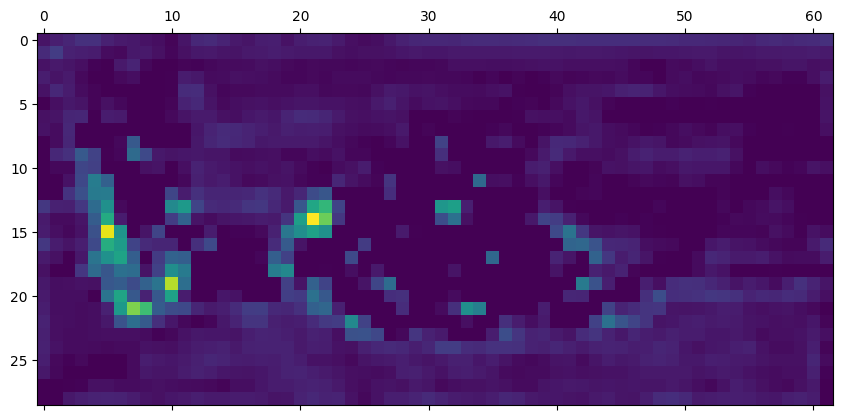

In [11]:

from torchvision.io import read_image

img= read_image('images/H160.png')

img = img.unsqueeze(0)
img.size()
model.eval()
img = img[:,1:4,:,:].float()
pred = model(img)
P=pred.argmax()
P=int(P)
pred[:,P].backward()
gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[2,3])
activations = model.get_activations().detach()
activations.size()
pooled_gradients.size()
for i in range(512):
    activations[ :,i, :, :] *= pooled_gradients[:,i]
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)

heatmap /= torch.max(heatmap)

import matplotlib.pyplot as plt
# draw the heatmap
plt.matshow(heatmap.squeeze())

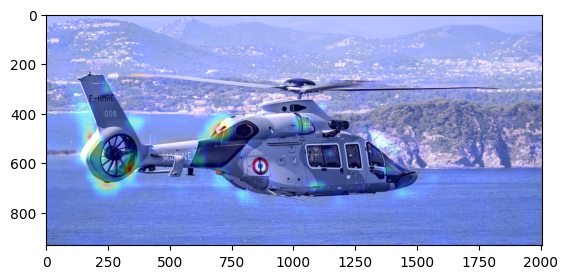

In [12]:
import cv2
img = cv2.imread('./images/H160.png')
heatmap = np.array(heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.3 + img
superimposed_img_8bit = cv2.convertScaleAbs(superimposed_img)
cv2.imwrite('./images/map.jpg', superimposed_img)
plt.imshow(cv2.cvtColor(superimposed_img_8bit, cv2.COLOR_BGR2RGB))


Ok this seems to be relevant, the mapping is concentraded over this beautifull H160!

<div class='alert alert-success'>


<b>This was an easy stuff, no? Let's go further and try to improve our assessment over the quality of explanation. </b>


</div>

If we wan't to go further, we firsly need to have a good metrics. As proposed in the paper, I 've chosen a sperman correlation in order to evaluate the difference between to mapping 

# $k$ -Fold Cross-Training

To explain the algorithm: the idea is to generate 10 different training subsets. For each of these subsets, we will conduct training. For each of the networks, we will map the heatmap with inferences for 1000 samples. Consequently, for each of the 10 networks, we will have heatmaps for the 1000 samples. We can then check whether the heatmaps are similar based on whether the sample was used for training or not.

### Distance metric
In the first step, we need a metric to measure the distance between the heatmaps

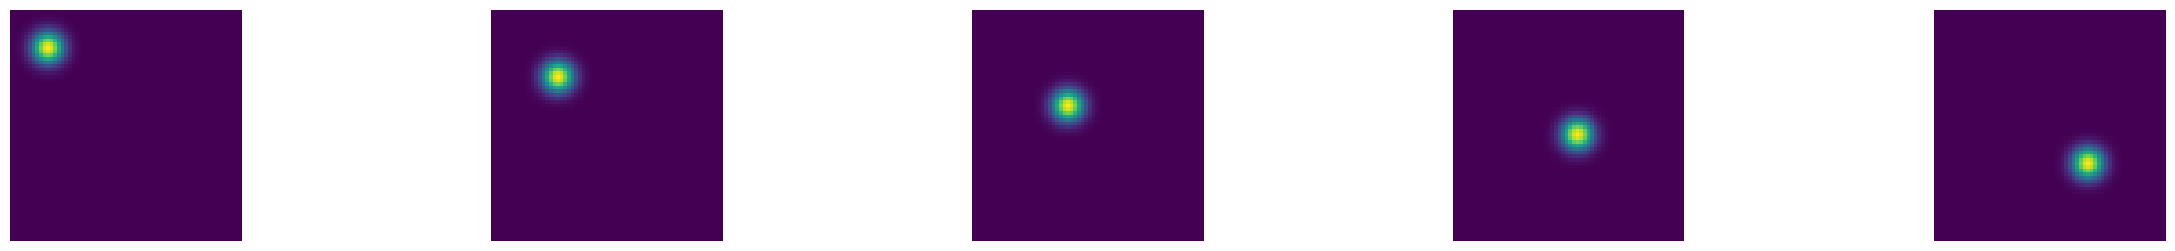

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from util.functions import generate_images 
from util.functions import spearman_image_correlation
from util.functions import divergence_KL_1
from util.functions import spearman_noise_correlation



dist =np.arange(10,50,8)
fig, axes = plt.subplots(1, 5, figsize=(30, 3))

for i in range(5):
    axes[i].imshow(generate_images(x=dist[i],y=dist[i]), cmap='viridis')
    axes[i].axis('off') 

plt.show()

In [14]:

image_origin = generate_images(x=10,y=10,noisy=False)
dist = 10

measure_assemnent = [(spearman_image_correlation(image_origin,generate_images(x=dist,y=dist,noisy=False)))for dist  in np.arange(10,50,1)]

Let's see if this metric seems to measure distance. One would expect the distance to improve as the points get farther apart

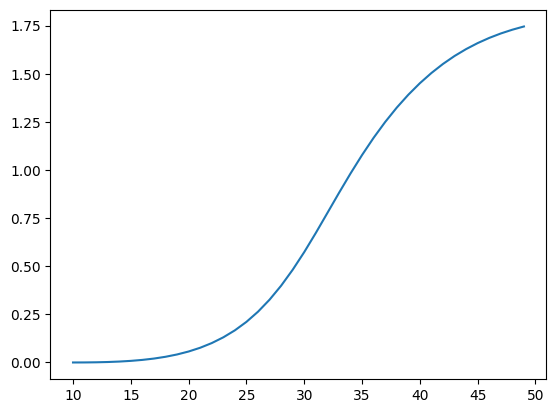

In [15]:
plt.plot(np.arange(10,50,1),measure_assemnent)

Ok it seems to be ok. If you want to play, I've added some noise and I would be pleased to speak with you about your results

## Dataset Splitting and learning

Now, it's time to roll up our sleeves. We are going to build the following algorithm:

<center>
    <figure>
        <img src="./figures/algo.png" alt="algo" width = "600" height="800">
        <figcaption>Training procedure [1].</figcaption>
    </figure>
</center>



On this next cell, some classes have been built to generate k = num_subset sub-datasets from a standard dataset, each composed of 'sparsity*100' percent of the original dataset. Note that all the sub-datasets maintain the same class proportions as the original one. You can take a look at the GenerateDataset class to see the implementation. As it is essential to retrieve the indices of each sub-dataset, they are recorded and will be processed next. Once our sub-datasets are computed, it's time to train each dataset using the ResName neural network.

You can choose betwen for ResName:

A simple CNN : SimpleCNN 
Resnet18 
VGG
and VGG_Cifar (the difference is here because Cifar10 is a colored dataset)

And betwen MNINST, FashionMNIST, or CIFAR10 (exclusively with VGG_Cifar)



<div class ='alert alert-info>
Our benchmark neural network will be a simple network corresponding to the following graph. This will allow for quick training for the purposes of the exercise
</div

<div class ='alert alert-info'>
For the purpose of this exercice, our benchmark neural network will be a simple network corresponding to the following graph.
 This will allow for quick training for the purposes of the exercise
 </div>

<center>
    <figure>
        <img src="./figures/SimpleCNN.png" alt="SimpleCNN" width = "700" height="800">
        <figcaption>SimpleCNN.</figcaption>
    </figure>
</center>

Now let's execute the first part of the algorithm, which involves generating the dataset, training on each dataset, and measuring explainability for 1000 samples.

<center>
    <figure>
        <img src="./figures/algo_step1.png" alt="Eplain" width = "500" height="300">
        <figcaption>Generation, training and explain [1].</figcaption>
    </figure>
</center>

In [16]:
%time
num_subset = 10
name_dataset = 'FashionMNIST'
name_folder = 'FashionMNIST'
sparsity = 0.8
image_size = 28
ResName = 'SimpleCNN'
num_epoch=30
batch_size=512
learning_rate=0.01
import time


from util.GenerateAndTrain import GenerateDataset
from util.generate_indice_global import generate_indice_global



NotebookCase=GenerateDataset(num_subset=num_subset, name_dataset=name_dataset, name_folder=name_folder,image_size=image_size,sparsity=sparsity)
NotebookCase.add_network_type(ResName=ResName)
NotebookCase.generate()
NotebookCase.train_sub_dataset(ResName,num_epoch=num_epoch,batch_size=batch_size,learning_rate=learning_rate)


from util.Heatmap import ComputeHeatmap
num_sample = 1000
test = ComputeHeatmap(NotebookCase,num_sample)
test.compute_heatmap()
heatmap_global = test.get_heatmap()
pred_acc = test.get_pred_acc()
indices_global,printed_list = generate_indice_global( NotebookCase, num_sample)





CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs
FashionMNIST already logged in .gitignore
./FashionMNIST
****************************************************************************************************
Creation of the weight vector for normalizing the sub-dataset.
Distribution of classes:  {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}


/Users/guillaumeberthelot/SDD/NotebookHowGoodIsYourExplanation/util/GenerateAndTrain.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.dataset_train.targets)


len class weight all : 60000
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
       dtype=torch.float16)
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Creation of global train dataset (will be use to test discrepancies)
FashionMNIST_dataset_train_global.pt recorded on folder ./FashionMNIST 
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Creation of validation dataset (is the same for all sub dataset)
FashionMNIST_train_dataval.pt recorded on folder ./FashionMNIST 
----------------------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

****************************************************************************************************
Creation of sub dataset number 0 over 10
FashionMNISTindices_data_sampler_0_10.pkl recorded on folder FashionMNIST


 10%|█         | 1/10 [00:07<01:04,  7.14s/it]

FashionMNIST_train_dataset_0.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 1 over 10
FashionMNISTindices_data_sampler_1_10.pkl recorded on folder FashionMNIST


 20%|██        | 2/10 [00:14<00:58,  7.26s/it]

FashionMNIST_train_dataset_1.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 2 over 10
FashionMNISTindices_data_sampler_2_10.pkl recorded on folder FashionMNIST


 30%|███       | 3/10 [00:21<00:50,  7.20s/it]

FashionMNIST_train_dataset_2.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 3 over 10
FashionMNISTindices_data_sampler_3_10.pkl recorded on folder FashionMNIST


 40%|████      | 4/10 [00:28<00:42,  7.16s/it]

FashionMNIST_train_dataset_3.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 4 over 10
FashionMNISTindices_data_sampler_4_10.pkl recorded on folder FashionMNIST


 50%|█████     | 5/10 [00:35<00:35,  7.12s/it]

FashionMNIST_train_dataset_4.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 5 over 10
FashionMNISTindices_data_sampler_5_10.pkl recorded on folder FashionMNIST


 60%|██████    | 6/10 [00:43<00:29,  7.33s/it]

FashionMNIST_train_dataset_5.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 6 over 10
FashionMNISTindices_data_sampler_6_10.pkl recorded on folder FashionMNIST


 70%|███████   | 7/10 [00:50<00:22,  7.34s/it]

FashionMNIST_train_dataset_6.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 7 over 10
FashionMNISTindices_data_sampler_7_10.pkl recorded on folder FashionMNIST


 80%|████████  | 8/10 [00:58<00:14,  7.41s/it]

FashionMNIST_train_dataset_7.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 8 over 10
FashionMNISTindices_data_sampler_8_10.pkl recorded on folder FashionMNIST


 90%|█████████ | 9/10 [01:05<00:07,  7.42s/it]

FashionMNIST_train_dataset_8.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
****************************************************************************************************
Creation of sub dataset number 9 over 10
FashionMNISTindices_data_sampler_9_10.pkl recorded on folder FashionMNIST


100%|██████████| 10/10 [01:13<00:00,  7.33s/it]

FashionMNIST_train_dataset_9.pt recorded on folder ./FashionMNIST 
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Training of subset n 0 over 10 on SimpleCNN
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


Epoch 0/29
----------


/Users/guillaumeberthelot/anaconda3/envs/SDD_Torch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6389 Acc: 0.7741
val Loss: 0.4137 Acc: 0.8482

Epoch 1/29
----------
train Loss: 0.3637 Acc: 0.8709
val Loss: 0.3321 Acc: 0.8802

Epoch 2/29
----------
train Loss: 0.3119 Acc: 0.8884
val Loss: 0.3007 Acc: 0.8926

Epoch 3/29
----------
train Loss: 0.2724 Acc: 0.9027
val Loss: 0.2887 Acc: 0.8969

Epoch 4/29
----------
train Loss: 0.2492 Acc: 0.9089
val Loss: 0.2708 Acc: 0.9039

Epoch 5/29
----------
train Loss: 0.2271 Acc: 0.9187
val Loss: 0.2653 Acc: 0.9052

Epoch 6/29
----------
train Loss: 0.1956 Acc: 0.9294
val Loss: 0.2508 Acc: 0.9094

Epoch 7/29
----------
train Loss: 0.1888 Acc: 0.9324
val Loss: 0.2492 Acc: 0.9121

Epoch 8/29
----------
train Loss: 0.1862 Acc: 0.9336
val Loss: 0.2469 Acc: 0.9122

Epoch 9/29
----------
train Loss: 0.1829 Acc: 0.9346
val Loss: 0.2465 Acc: 0.9135

Epoch 10/29
----------
train Loss: 0.1801 Acc: 0.9358
val Loss: 0.2451 Acc: 0.9134

Epoch 11/29
----------
train Loss: 0.1786 Acc: 0.9363
val Loss: 0.2464 Acc: 0.9138

Epoch 12/29
----------
t

  0%|          | 0/10 [00:00<?, ?it/s]/Users/guillaumeberthelot/SDD/NotebookHowGoodIsYourExplanation/util/Heatmap.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(self.train_dataset[i][0])
/Users/guillaumeberthelot/SDD/NotebookHowGoodIsYourExplanation/util/Heatmap.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(self.train_dataset[i][1])
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

[19179 23010 28841 ... 15481 52404 32112]
[19701 47571   478 ... 54682 19130 29074]
[40372 14177 52659 ... 24240  4954 18817]
[24917 32017 16874 ... 57990 36463 40207]
[ 2589 36079 50922 ... 34040 59329  6190]
[47107 37786 35969 ... 37777 32035 57206]
[31780 58236 43718 ... 48712  4167 39658]
[43548 40990 11132 ... 39372 56039 12832]
[  983 36536 36594 ... 20397 30958 53110]
[43965 30399 55865 ... 29045 44625  6741]


### Which sample has been chosen ?

In [17]:
printed_list

,Was trained on dataset 0 : (Yes/No),Was trained on dataset 1 : (Yes/No),Was trained on dataset 2 : (Yes/No),Was trained on dataset 3 : (Yes/No),Was trained on dataset 4 : (Yes/No),Was trained on dataset 5 : (Yes/No),Was trained on dataset 6 : (Yes/No),Was trained on dataset 7 : (Yes/No),Was trained on dataset 8 : (Yes/No),Was trained on dataset 9 : (Yes/No)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
998,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


I propose that you take a look at all the classes that have been written. Now, we are at the second stage of the algorithm, It was a little bit tricky

And now, let's make this a bit more visually appealing.

<div class='alert alert-success'>
So, we created 10 sub-datasets, trained them, and generated heatmaps for each of the first 1000 samples. Can we now visualize an example of the heatmap generated for a sample? You will see in the following figure the 10 inferences made by the 10 sub-datasets for the same sample
</div>

/var/folders/52/k6pzm88n5_xdgm1mjpjcgnc80000gn/T/ipykernel_84974/2767148446.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(train_dataset[sample][0])


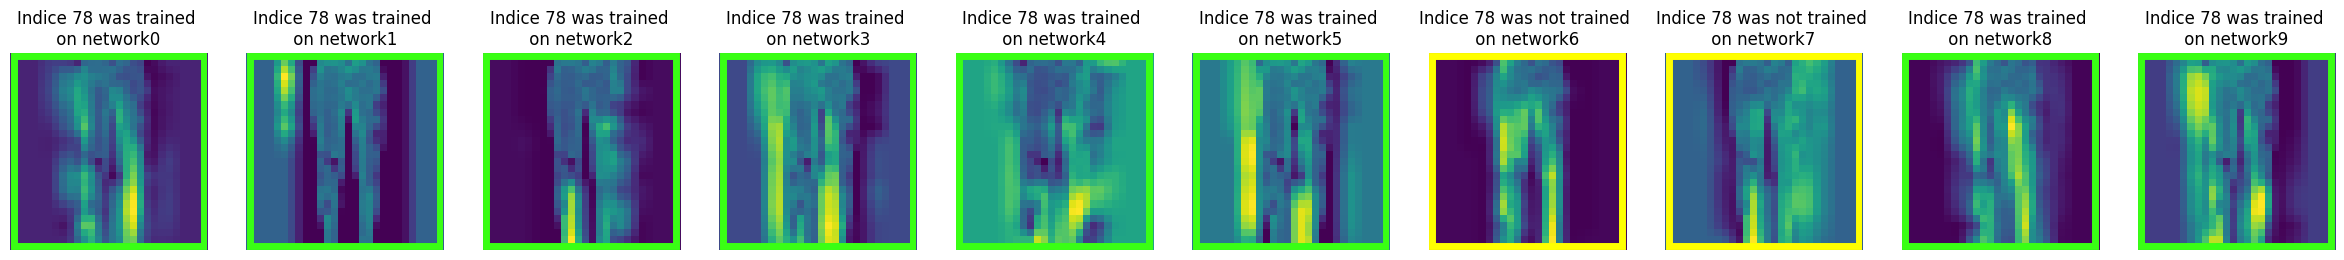

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sample=78
fig, axes = plt.subplots(1, 10, figsize=(30, 3))
train_dataset = torch.load(f'{name_folder}/{name_dataset}_dataset_global.pt')
img=torch.tensor(train_dataset[sample][0])

img = img[0,:,:]

for i in range(10):
    heatmap = heatmap_global[i][sample].squeeze()
     #heatmap = np.uint8(255*heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = 0.05*img+0.5*heatmap
    axes[i].imshow(superimposed_img,cmap = 'viridis')
    axes[i].axis('off') 
    
    if indices_global[sample,i]==1:
          rect = patches.Rectangle((0, 0), image_size-1, image_size-1, linewidth=5, edgecolor='#39FF14', facecolor='none')
          axes[i].add_patch(rect)
          axes[i].set_title(f'Indice {sample} was trained \n on network{i} ')
    else :
          axes[i].set_title(f'Indice {sample} was not trained \n on network{i} ')
          rect = patches.Rectangle((0, 0), 27, 27, linewidth=5, edgecolor='yellow', facecolor='none')
          axes[i].add_patch(rect)



plt.show()



### $S^=$ and $S^{\neq}$
We define S-equal as the set of elements that received correct labels, and S-diff as the set of elements that received both correct and incorrect inferences. We expect, for good explainability, that the distances for S-equal are lower than for S-diff."

## Let's compute $S^=$ and $S^{\neq}$

We define S-equal as the set of elements that received correct labels, and S-diff as the set of elements that received both correct and incorrect inferences. We expect, for good explainability, that the distances for S-equal are lower than for S-diff."
Here after you'll find the second parts of the algorithm : 

<center>
    <figure>
        <img src="./figures/algo_step_2.png" alt="Eplain" width = "500" height="400">
        <figcaption>Computing S equal and S diff[1].</figcaption>
    </figure>
</center>

This is where we use our metric, the spearman correlation

In [19]:

from util.functions import spearman_image_correlation
S_equal =[]
S_diff =[]
for i in range(num_subset):
    for p in range(num_sample):
        if indices_global[p,i]==0:
            phi_i_x = heatmap_global[i][p]
            pred_i = int(pred_acc[p,i])
            for j in range(num_subset):
                if i==j :
                    pass
                else :
                    if indices_global[i,j]==1:

                        phi_j_x = heatmap_global[j][p]
                        pred_j = int(pred_acc[p,j])
                        spear_coor = spearman_image_correlation(phi_i_x,phi_j_x)
                        if (pred_i==1 & pred_j==1):
                            S_equal.append(spear_coor)
                        elif (pred_i==1 ^ pred_j==1): 
                            S_diff.append(spear_coor)
                        else :
                            pass


                        

                        

Let's now calculate the two metrics for which we've just done all this work, MeGe and ReCo. For each of these metrics, ranging from 0 to 1, the optimal performance is achieved when they are close to 1.

$$ MeGe = \left(1 + \frac{1}{\lvert S^= \rvert} \sum_{\delta \in S^=} \delta \right)^{-1} $$



$$ReCo = \max_{\gamma \in S} TPR(\gamma)+TNR(\gamma)-1

MeGe stands for Generalizability: a good explanation should point to identical evidence. 

Reco : relative consistency, denoted as ReCo: when an image is misclassified, the explanation should point to different areas than those used for a correct explanation.

In [20]:

import numpy as np
S=S_equal+S_diff


def calculate_TPR_plus_TNR_minus_1(S,S_equal,S_diff,gamma):
    
    

    num_tpr = len([delta for delta in S_equal if delta <= gamma])
    denom_tpr = len([delta for delta in S if delta <= gamma])
    num_tnr = len([delta for delta in S_diff if delta > gamma])
    denom_tnr = len([delta for delta in S if delta > gamma])
    if (denom_tpr==0 or denom_tnr==0):
        return -np.inf
    else :
        return num_tpr/denom_tpr+num_tnr/denom_tnr-1

ReCo = np.max([calculate_TPR_plus_TNR_minus_1(S,S_equal,S_diff,gamma) for gamma in S])

MeGe = 1/(1+(1/len(S_equal))*np.sum(S_equal))

In [21]:
ReCo

0.4832206944768118

In [22]:
MeGe


0.6616899314857999

We can now observe the distribution of S_equal and S_diff. A good explicability will have a strong density of S_equal for low distance values and a density of S_diff centered around high distance values.

Here you can see the result obtained in the paper for a case :{ GradCAM, ResNet18, CIFAR10}
<center>
    <figure>
        <img src="./figures/result.png" alt="Eplain" width = "500" height="300">
        <figcaption>Distance mapping for GradCAM over ResNet18 with CIFAR10 [1].</figcaption>
    </figure>
</center> 

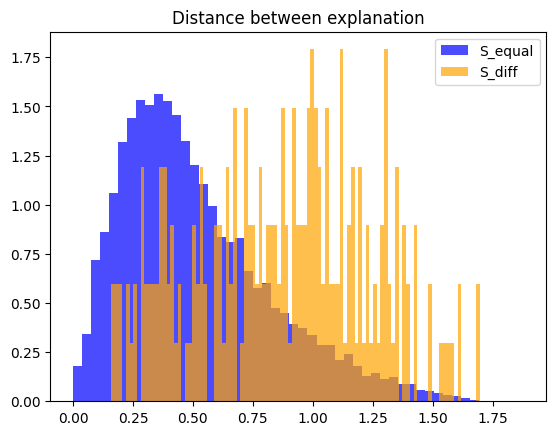

In [23]:
plt.hist(S_equal, bins=50, alpha=0.7, label='S_equal', color='blue', density=True)
plt.hist(S_diff, bins=100, alpha=0.7, label='S_diff', color='orange', density=True)
plt.x_axis=('Distance')
plt.title('Distance between explanation')
plt.legend()
plt.show()


<div class ='alert alert-success'>
In conclusion, we can see that our simple network used to train FashionMNIST exhibits good explainability. Indeed, the values of ReCo and MeGe are favorable, and furthermore, we observe a clear separability of the densities for S-equal and S-diff. You can now test other datasets on different neural networks


</div>

<div class ='alert alert-info'>
We have obtained initial results for evaluating the interpretability method applied to my simple neural network. You can apply it to other cases (VGG, ResNet) and other datasets (MNIST, CIFAR10). One noticeable observation is the relative instability of this method. Indeed, I have never obtained identical results for two different runs. This is likely linked to the size of the evaluated sample (1000), which represents only 1/60 of the entire dataset. It's possible to try running the algorithm on the entire dataset, but the computation time is long (num_sample = 60000). However, the primary cause of instability is likely the limited number of sub-datasets and training instances. We conducted 10 trainings, and it may be necessary to increase this number, albeit at the expense of higher computational and memory costs.
</div>